In [12]:
import os
os.chdir('/home/gsalinas/Documents/GitHub/axionns/')

import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp

from classes.ns import NeutronStar
from classes.particles import Particles

from scripts.basic_functions import output_dir, G_N, conv_factor_eV_GHz, conv_factor_G_eV2, conv_factor_km_eVinv, mag_vector, c, angle_between_vecs
from scripts.conversion import find_all_hits, divide_into_singles, find_hits

plt.rcParams['figure.figsize'] = [24, 16]

In [35]:
event = 'dASXPJKEG'
part_trajs = np.load(output_dir + event + '/' + event + '.npy')
single_particles = divide_into_singles(part_trajs)

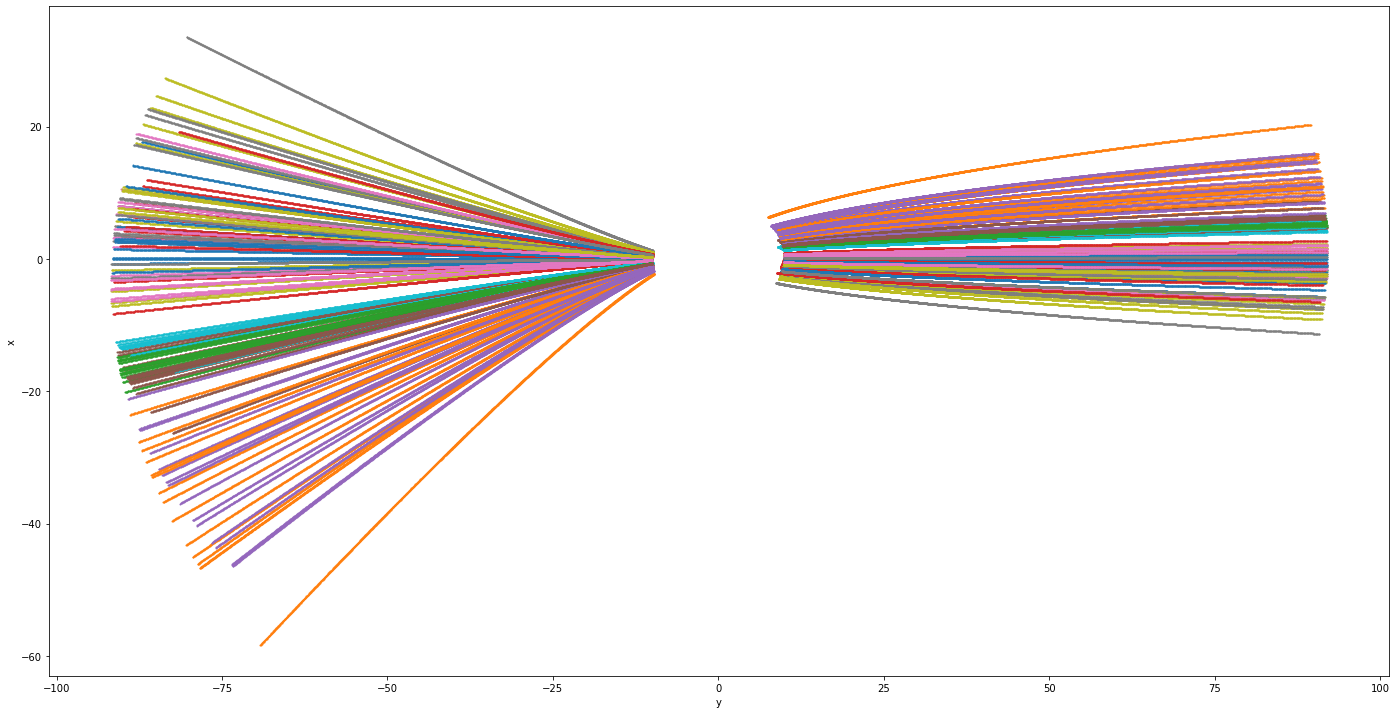

In [24]:
############################ Plot some trajectories ###########################################
ax = plt.gca()
ax.set_aspect('equal')
nsamples = len(single_particles)
for i in np.arange(int(part_trajs[-1][0])):
    traj_chosen = np.array([[part_traj[3], part_traj[2]] for part_traj in part_trajs if part_traj[0] == i]).T
    ax.scatter(traj_chosen[0], traj_chosen[1], s = 1)

plt.xlabel('y')
plt.ylabel('x');

In [25]:
M_NS, R_NS = 1, 10
NS = NeutronStar(M_NS, R_NS)

In [37]:
if __name__ == '__main__':
    mp.freeze_support()
    ncores = mp.cpu_count() - 1
    pool = mp.Pool(ncores)

    all_hits = find_all_hits(single_particles, NS, pool)

In [30]:
np.save(output_dir + event + '/' + event + '_conversion.npy', all_hits)

In [44]:
all_ts = np.array(all_hits).T[1]
min_t = np.min(all_ts)
all_ts -= min_t
all_ts /= 3600.

hist_ts = np.histogram(all_ts, bins = np.linspace(0, np.max(all_ts), 50))
max_hist = np.max(hist_ts[0])
indices_hist = np.where(hist_ts[0] > 0.9*max_hist)
index_max_t, index_min_t = indices_hist[0][-1] + 1, indices_hist[0][0] - 1
max_t, min_t = hist_ts[1][index_max_t], hist_ts[1][index_min_t]#
indices = np.where(np.logical_and(all_ts > min_t, all_ts < max_t))
chosen_hits = all_hits[indices]

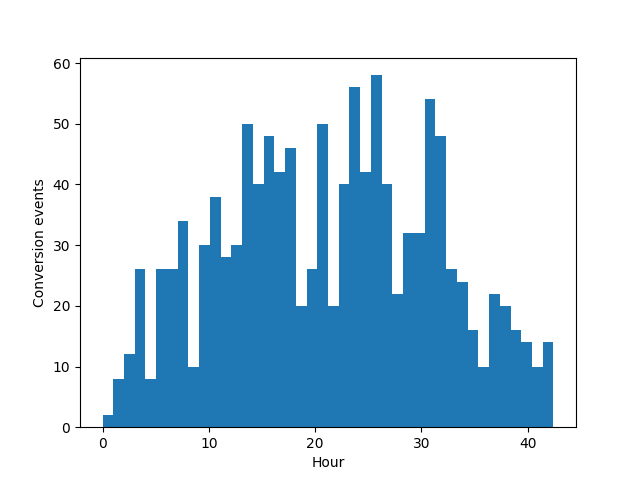

In [14]:
%matplotlib widget

all_ts = np.array(all_hits).T[1]
all_ts -= np.min(all_ts)
all_ts /= 3600.
plt.hist(all_ts, bins=np.linspace(0, np.max(all_ts), int(np.max(all_ts)) + 1));
plt.xlabel('Hour')
plt.ylabel('Conversion events');

In [11]:
chosen_hour = 20
indices = np.where(np.logical_and(np.sort(all_ts) > chosen_hour, np.sort(all_ts) < chosen_hour + 1))[0]
chosen_hits = all_hits[indices[0]: indices[-1]]

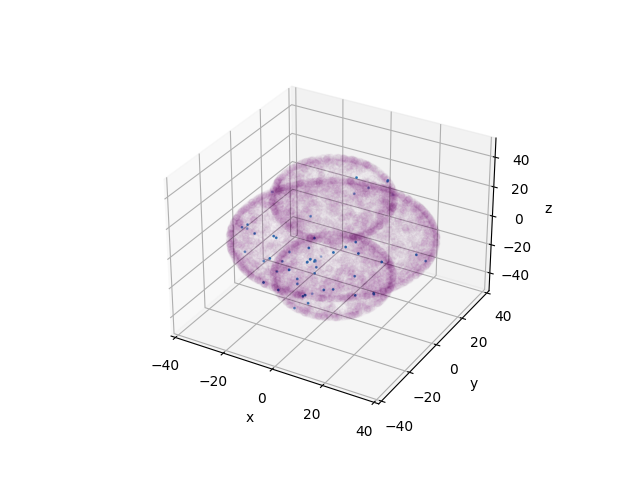

In [18]:
%matplotlib widget

X, Y, Z = np.array(chosen_hits).T[2:5]
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, s = 1);

Xsurf, Ysurf, Zsurf = NS.conversion_surface_est(0., Particles.axionmass).T
ax.scatter3D(Xsurf, Ysurf, Zsurf, c = 'purple', alpha = 0.01);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_zlabel('z');

In [21]:
gag = 1. # In units of 10^{-14} GeV-1

axionmass_GHz = Particles.axionmass*1.e-5*conv_factor_eV_GHz

all_gammas = []
for hit in all_hits:
    time, position, velocity = hit[1], hit[2:5], hit[5:]
    BNS = NS.magnetic_field([position], time)[0]  # In units of

    gamma = 1/np.sqrt(1 - np.power(mag_vector(velocity)/c, 2))
    all_gammas.append(gamma)

    k = gamma*axionmass_GHz*mag_vector(velocity)/c    # in GHz
    omega2 = np.power(axionmass_GHz, 2) + np.power(k, 2) # in GHz^2
    theta = angle_between_vecs(BNS, velocity)
    wp_bar2 = np.power(axionmass_GHz, 2)*omega2/(np.power(axionmass_GHz*np.cos(theta), 2) + omega2*np.power(np.sin(theta), 2))  # in GHz^2

    x_dir = np.cross(velocity, BNS)
    y_dir = np.cross(velocity, x_dir)
    y_hat = y_dir/mag_vector(y_dir)

    s_dir = wp_bar2*np.cos(theta)*np.sin(theta)/(omega2 - wp_bar2*np.power(np.cos(theta), 2))*y_hat + velocity/mag_vector(velocity)
    s_hat = s_dir/mag_vector(s_dir)

    epsilon = 1e-8
    new_position = position + s_hat*epsilon
    new_omega2 = np.power(np.sqrt(omega2) - G_N*NS.mass*axionmass_GHz/np.power(mag_vector(position)*c,2)*(mag_vector(new_position) - mag_vector(position)), 2) # in GHz^2
    new_theta = angle_between_vecs(NS.magnetic_field([new_position], time)[0], velocity)
    new_wp_bar2 = np.power(axionmass_GHz, 2)*new_omega2/(np.power(axionmass_GHz*np.cos(new_theta), 2) + new_omega2*np.power(np.sin(new_theta), 2))  # in GHz^2

    wp_bar_prime = (new_wp_bar2 - wp_bar2)/(2*epsilon*np.sqrt(wp_bar2))

    prob = conv_factor_eV_GHz*conv_factor_G_eV2*conv_factor_G_eV2*conv_factor_km_eVinv*1.e-18/2.*np.power(gag*mag_vector(BNS)*np.sin(theta), 2)*np.pi*np.power(axionmass_GHz, 5)/(2*k*np.abs(wp_bar_prime))/np.power(np.power(k, 2) + np.power(axionmass_GHz*np.sin(theta), 2), 2)

0.03638889594522843
0.03073101778153331
0.014293906864764139
0.012849672475612466
0.019729038447286386
0.17395550227248188
0.09560302630240788
0.107637877722568
0.21626233967158076
0.019300257909402842
0.03096692493568911
0.032299986739914854
0.019832363315550373
4.104959398399229
0.1721498968274535
0.49564026633001784
0.789631371487662
0.018887330467588483
0.014583660273275604
0.016140395020976823
0.14212386080550143
0.26234008913534995
0.24569255432863324
0.025367188749665037
0.01718532993048221
0.02151510948515898
0.008861293740617001
0.008222332696100298
0.016788098245869052
0.10732579433799704
0.061607083102298114
0.06292115013095101
0.11587957222438047
0.01575324378950259
0.014995931666401442
0.015991231062857852
0.009810254604234155
0.009716957259226462
0.019049297790675056
0.9409288953064584
0.1286049980731241
0.1457225057551601
1.6780099352845985
0.0181098841127136
0.04141083196376698
0.04038521980237218
0.03344216205131024
0.03408499917322114
0.019369479035394748
0.0181272504